## Libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Data

In [2]:
# Load the data. make sure to replace 'the_path_to_the_data.csv' with the actual file path.
data = pd.read_csv("mpi.csv")

In [ ]:
# Split data into train and test set (90% train, 10% test)
# test_size = 0.1

# Randomly shuffle the dataset
# shuffled_data =  data.sample(data.shape[0], random_state=12).reset_index(drop=True)

# Get the indices (i.e index mapping) for the test sets
# test_indices = shuffled_data.sample(frac=test_size, random_state=12).index

# Separate data into train and test sets using a boolean indexing
# train_data = shuffled_data[~shuffled_data.index.isin(test_indices)]
# test_data = shuffled_data[shuffled_data.index.isin(test_indices)]

# print(f"Train data Dimension: {train_data.shape}")
# print(f"Test data Dimension: {test_data.shape}")

## Data Preprocessing

In [3]:
def data_preprocessing(
        data, 
        target_var, 
        drop_zone_state=False, 
        drop_high_cor_features=False, 
        corr_threshold=0.80
) -> tuple:
    """ 
    :params
        data: The Train dataset.
        target_var: Model traget veriable column name.
        drop_zone_state: Whether to drop the 'Zone' & 'State' variables. If false these variables will be
                        encoded using a one-hot encoder.
        drop_high_cor_features: Whether to drop columns that are highly correlated with the target variable `target_var`
    :return
        A tuple with a length of 4 sets.
    """

    # A list of features to drop
    X_drop_cols = [
        'LGA', 'HH No', 'Household_ID', 'Age', 'Sex', 'HouseholdSize', 'Counting Vector', 
        'MPI Identification with k=26%', 'Individual Weight', 'Household Weight', 'Population Weight'
    ]

    if drop_zone_state:
        X_drop_cols = X_drop_cols + ['Zone', 'State']

    # Separate features (X) and target variable (y)
    X = data.drop(X_drop_cols + [target_var], axis=1)  
    y = data[target_var]

    # Feature Engineering
    if not drop_zone_state:
       X = pd.get_dummies(X, columns=["Zone", "State"], dtype="int")

    if drop_high_cor_features:
        cor_df = pd.DataFrame()
        cor_df[target_var] = y
        cor_df[list(X.columns)] = X
        # Correlation analysis
        cor_df = cor_df.corr()
        cor_df = cor_df[[target_var]]
        cor_df = cor_df.iloc[1:, :]

        highly_correlated_features = list(cor_df[cor_df[target_var] >= corr_threshold].index)

        if highly_correlated_features != []:
            X = X.drop(highly_correlated_features, axis=1)
    
    # Split data into train, validation, and test sets.
    # 80% of the initial data will be assigned to the train set.
    # 20% will be assigned to the validation set.
    # We use `random_state=42` for reproducibility on different seassion or computer.

    # X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=12)
    # return X_train, X_val, y_train, y_val
    return X, y

In [4]:
def split_data(X, y, only_train_val=True):
    """ 
    """

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)
    
    if only_train_val:
        return X_train, X_val, y_train, y_val
    else:
        return X_train, X_val, X_test, y_train, y_val, y_test

In [79]:
# X_train, X_val, y_train, y_val = split_data(train_data, "Poverty Identification with k=26%", False, True)

In [5]:
def train_eval_model(X_train, X_val, y_train, y_val, model):
    """ 
    """
    # Train and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # Evaluation
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print("-"*60)

    cl_report = classification_report(y_val, y_pred)
    print("Classification Report:")
    print(cl_report)

    return model

##### Imporve model performence by using different combinations of hyperparameter 

In [ ]:
# Define hyperparameter search space
# param_grid = {
#     "n_estimators": [100, 200, 300],
#     "max_depth": [4, 6, 8],
#     "min_samples_split": [2, 5, 10],
    #   "min_samples_leaf": [1, 2, 4],
# }

# # Create a RandomForestRegressor model
# rf_model = RandomForestClassifier(random_state=42)

# # Use RandomizedSearchCV for hyperparameter tuning with cross-validation
# grid_search  = GridSearchCV(
#     rf_model, 
#     param_grid=param_grid, 
#     cv=5, 
#     scoring="accuracy", 
#     random_state=42
# )

# grid_search.fit(X_train, y_train)

# # Get the best model with tuned hyperparameters (The set of estimator that achieved the best accuracy)
# best_rf_model = grid_search.best_estimator_

# # You can access the tuned hyperparameters using best_rf_model.get_params()
# print("Best Hyperparameters:", best_rf_model.get_params())

# # Train the best model on the entire training set.
# best_rf_model.fit(X_train, y_train)

# # Make predictions on the validation set (for the model evaluation)
# y_pred_val = best_rf_model.predict(X_val)

# # Evaluate the model performance on the validation set (e.g., using accuracy)
# validation_accuracy = accuracy_score(y_val, y_pred_val)
# print("Random Forest model validation accuracy:", validation_accuracy)

## Handling target variable data imbalance (downsampling)

In [10]:
data["Poverty Identification with k=26%"].value_counts()

Poverty Identification with k=26%
1    645
0    355
Name: count, dtype: int64

In [11]:
data["Poverty Identification with k=26%"].value_counts(normalize=True)*100

Poverty Identification with k=26%
1    64.5
0    35.5
Name: proportion, dtype: float64

In [12]:
# The minimum sample class
min_sample_class = data["Poverty Identification with k=26%"].value_counts(sort=True).index[1]
max_sample_class = 1 if min_sample_class == 0 else 0

print(f"Min sample class: {min_sample_class}")
print(f"Max sample class: {max_sample_class}")

# Get the total number of households that falls within the 0 class
n_downsamples = data[data["Poverty Identification with k=26%"] == min_sample_class].shape[0]

print(f"Number of downsamples {n_downsamples}")

Min sample class: 0
Max sample class: 1
Number of downsamples 355


In [13]:
# Filter only incomes with <= 50 thousand and sample 2,500 records.
max_class_data = data[data["Poverty Identification with k=26%"] == max_sample_class].sample(
    n=n_downsamples, replace=False, random_state=12, ignore_index=True
)

min_class_data = data[data["Poverty Identification with k=26%"] == min_sample_class]

# Combine downsampled data (<=50K) and >50K data.
downsample_data = pd.concat([max_class_data, min_class_data], axis=0)

# Remove dulicates row
data_downsample = downsample_data.drop_duplicates()

# Print sampled shape
print(downsample_data.shape)

# Shuffle dataset
downsample_data = downsample_data.sample(n=downsample_data.shape[0], replace=False, ignore_index=True)

(710, 29)


In [14]:
downsample_data["Poverty Identification with k=26%"].value_counts()

Poverty Identification with k=26%
1    355
0    355
Name: count, dtype: int64

## Training model

Train with:
+ Downsamples
+ Downsamples & less correlated features
+ Downsampels & less correlated features & dummy variables.
+ Less correlated features & dummary variables.
+ dummary variables.

### Dummary variables

In [6]:
X, y = data_preprocessing(data, "Poverty Identification with k=26%", False, False)
X_train, X_val, y_train, y_val = split_data(X, y, True)

# Logistic Regression
mdl = train_eval_model(
    X_train, X_val, y_train, y_val, 
    LogisticRegression(penalty="l1", C=0.1, solver="liblinear")
)

Accuracy: 0.9933
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        54
           1       1.00      0.99      0.99        96

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



In [7]:
mdl = train_eval_model(
    X_train, X_val, y_train, y_val, 
    RandomForestClassifier(max_depth=5, random_state=12)
)

Accuracy: 1.0000
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       1.00      1.00      1.00        96

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



### Less correlated features & dummary variables.

In [8]:
X, y = data_preprocessing(data, "Poverty Identification with k=26%", False, True, 0.75)
X_train, X_val, y_train, y_val = split_data(X, y, True)

# Logistic Regression
mdl = train_eval_model(
    X_train, X_val, y_train, y_val, 
    LogisticRegression(penalty="l1", C=0.1, solver="liblinear")
)

Accuracy: 1.0000
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       1.00      1.00      1.00        96

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



In [9]:
mdl = train_eval_model(
    X_train, X_val, y_train, y_val, 
    RandomForestClassifier(max_depth=5, random_state=12)
)

Accuracy: 1.0000
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       1.00      1.00      1.00        96

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



### Downsamples

In [15]:
X, y = data_preprocessing(downsample_data, "Poverty Identification with k=26%", True, False)
X_train, X_val, y_train, y_val = split_data(X, y, True)

# Logistic Regression
mdl = train_eval_model(
    X_train, X_val, y_train, y_val, 
    LogisticRegression(penalty="l1", C=0.1, solver="liblinear")
)

Accuracy: 0.9717
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        49
           1       1.00      0.95      0.97        57

    accuracy                           0.97       106
   macro avg       0.97      0.97      0.97       106
weighted avg       0.97      0.97      0.97       106



In [16]:
mdl = train_eval_model(
    X_train, X_val, y_train, y_val, 
    RandomForestClassifier(max_depth=5, random_state=12)
)

Accuracy: 1.0000
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        49
           1       1.00      1.00      1.00        57

    accuracy                           1.00       106
   macro avg       1.00      1.00      1.00       106
weighted avg       1.00      1.00      1.00       106



### Downsamples & less correlated features

In [18]:
X, y = data_preprocessing(downsample_data, "Poverty Identification with k=26%", True, True, 0.75)
X_train, X_val, y_train, y_val = split_data(X, y, True)

# Logistic Regression
mdl = train_eval_model(
    X_train, X_val, y_train, y_val, 
    LogisticRegression(penalty="l1", C=0.1, solver="liblinear")
)

Accuracy: 0.9623
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        49
           1       1.00      0.93      0.96        57

    accuracy                           0.96       106
   macro avg       0.96      0.96      0.96       106
weighted avg       0.97      0.96      0.96       106



In [19]:
mdl = train_eval_model(
    X_train, X_val, y_train, y_val, 
    RandomForestClassifier(max_depth=5, random_state=12)
)

Accuracy: 1.0000
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        49
           1       1.00      1.00      1.00        57

    accuracy                           1.00       106
   macro avg       1.00      1.00      1.00       106
weighted avg       1.00      1.00      1.00       106



### Downsampels & less correlated features & dummy variables.

In [20]:
X, y = data_preprocessing(downsample_data, "Poverty Identification with k=26%", False, True, 0.75)
X_train, X_val, y_train, y_val = split_data(X, y, True)

# Logistic Regression
mdl = train_eval_model(
    X_train, X_val, y_train, y_val, 
    LogisticRegression(penalty="l1", C=0.1, solver="liblinear")
)

Accuracy: 0.9623
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        49
           1       1.00      0.93      0.96        57

    accuracy                           0.96       106
   macro avg       0.96      0.96      0.96       106
weighted avg       0.97      0.96      0.96       106



In [21]:
mdl = train_eval_model(
    X_train, X_val, y_train, y_val, 
    RandomForestClassifier(max_depth=5, random_state=12)
)

Accuracy: 1.0000
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        49
           1       1.00      1.00      1.00        57

    accuracy                           1.00       106
   macro avg       1.00      1.00      1.00       106
weighted avg       1.00      1.00      1.00       106



## Feature Importance

In [22]:
X, y = data_preprocessing(downsample_data, "Poverty Identification with k=26%", False, True, 0.75)
X_train, X_val, y_train, y_val = split_data(X, y, True)

# Random forest classifier
mdl = train_eval_model(
    X_train, X_val, y_train, y_val, 
    RandomForestClassifier(max_depth=5, random_state=12)
)

Accuracy: 1.0000
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        49
           1       1.00      1.00      1.00        57

    accuracy                           1.00       106
   macro avg       1.00      1.00      1.00       106
weighted avg       1.00      1.00      1.00       106



In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
imp_df = (
    pd.DataFrame({
        "feature_importance": X_train.columns,
        "value": mdl.feature_importances_
    })
    .sort_values(by="value", ascending=False)
    .reset_index(drop=True)
)

imp_df

,feature_importance,value
0,Food security,2.059855e-01
1,Health,1.602657e-01
2,Housing,1.469535e-01
3,Nutrition,9.810308e-02
4,Asset,9.384611e-02
5,Water access,6.528850e-02
6,Water reliability,4.869673e-02
7,School attendance,4.254795e-02
8,Years of schooling,3.366106e-02
9,Unemployment,2.812775e-02


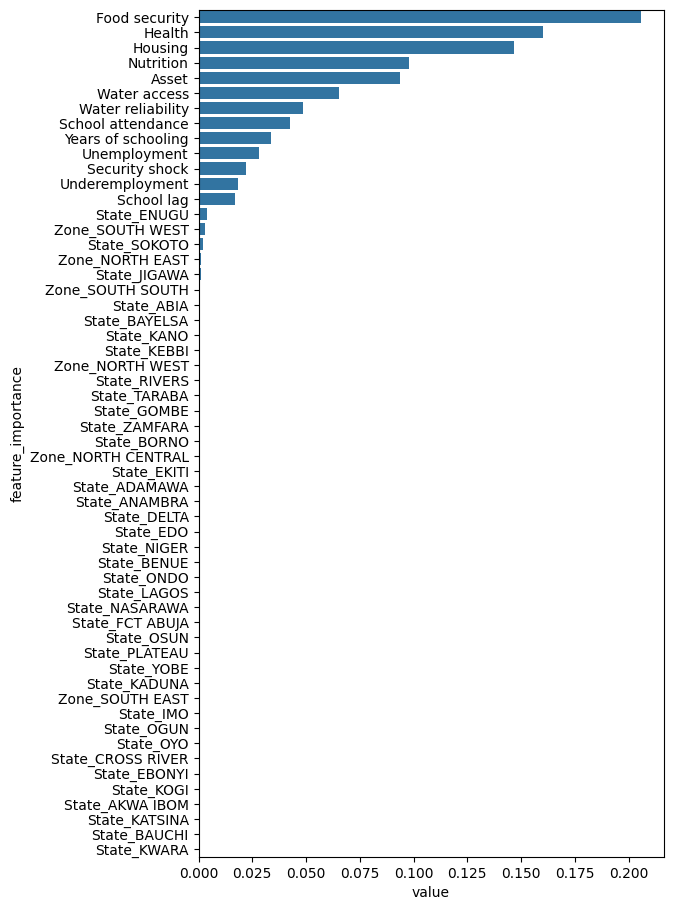

In [25]:
# Get feature importances
# feature_importances = mdl.feature_importances_
# fi_labels = X_train.columns

fig, ax = plt.subplots(figsize=(6, 11))
sns.barplot(
    data=imp_df,
    x = "value",
    y = "feature_importance"
)
plt.show()

# New data (test dataset)

In [ ]:
# Make predictions on the completely unseen test set (final evaluation)
# y_pred_test = best_rf_model.predict(X_test)

# Evaluate the model performance on the test set (e.g., using accuracy)
# test_accuracy = accuracy_score(y_test, y_pred_test)
# print("Random Forest model Test Accuracy:", test_accuracy)

In [136]:
test_data.columns

Index(['Zone', 'State', 'LGA', 'HH No', 'Household_ID', 'Sex', 'Age',
       'HouseholdSize', 'Nutrition', 'Food security', 'Health',
       'School attendance', 'Years of schooling', 'School lag', 'Water access',
       'Water reliability', 'Sanitation', 'Housing', 'Cooking', 'Asset',
       'Unemployment', 'Underemployment', 'Security shock', 'Counting Vector',
       'Poverty Identification with k=26%', 'MPI Identification with k=26%',
       'Individual Weight', 'Household Weight', 'Population Weight'],
      dtype='object')

In [28]:
X, y = data_preprocessing(downsample_data, "Poverty Identification with k=26%", False, True, 0.75)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, False)


# Predict and evaluate on test set
test_y_pred = mdl.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, test_y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("-"*40)

cl_report = classification_report(y_test, test_y_pred)
print("Classification Report:")
print(cl_report)

Accuracy: 1.0000
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        57

    accuracy                           1.00       107
   macro avg       1.00      1.00      1.00       107
weighted avg       1.00      1.00      1.00       107



## Using a simple (dummy) baseline model 

In [29]:
from sklearn.dummy import DummyClassifier

In [32]:
help(DummyClassifier)

Help on class DummyClassifier in module sklearn.dummy:

class DummyClassifier(sklearn.base.MultiOutputMixin, sklearn.base.ClassifierMixin, sklearn.base.BaseEstimator)
 |  DummyClassifier(*, strategy='prior', random_state=None, constant=None)
 |  
 |  DummyClassifier makes predictions that ignore the input features.
 |  
 |  This classifier serves as a simple baseline to compare against other more
 |  complex classifiers.
 |  
 |  The specific behavior of the baseline is selected with the `strategy`
 |  parameter.
 |  
 |  All strategies make predictions that ignore the input feature values passed
 |  as the `X` argument to `fit` and `predict`. The predictions, however,
 |  typically depend on values observed in the `y` parameter passed to `fit`.
 |  
 |  Note that the "stratified" and "uniform" strategies lead to
 |  non-deterministic predictions that can be rendered deterministic by setting
 |  the `random_state` parameter if needed. The other strategies are naturally
 |  deterministi

In [34]:
dummy_clf = DummyClassifier(strategy="uniform")

dummy_clf.fit(X_train, y_train)

dy_y_pred = dummy_clf.predict(X_val)

accuracy = accuracy_score(y_val, dy_y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("-"*40)

cl_report = classification_report(y_val, dy_y_pred)
print("Classification Report:")
print(cl_report)

Accuracy: 0.5094
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.53      0.50        49
           1       0.55      0.49      0.52        57

    accuracy                           0.51       106
   macro avg       0.51      0.51      0.51       106
weighted avg       0.51      0.51      0.51       106

